An implementation of the paper [***An Agent-based Simulation of Power Generation Company Behavior in Electricity
Markets under Different Market-Clearing Mechanisms***](https://www.sciencedirect.com/science/article/abs/pii/S0301421516305419) .

## Simulation Process
In our agent-based simulation model, agents represent the GenCos that are expected to satisfy demand on the transmission grid. GenCos submit bids sequentially for each hour of the next 24 hours to the ISO. The bidding process is synchronic for all GenCos, and each iteration in the simulation corresponds to an hour in the day-ahead-market. The simulation runs for a finite number of it-erations (maxt). At the end of each iteration/bid, each GenCo-i calculates its payoff $r_i$. In the simulation model, we assume that
- The demand is inelastic and constant, i.e., it does
not change from one hour to the next. GenCos participate only in the day-ahead market(no futures or real-time markets).
- No line or generation outage is experienced.
- GenCos do not change their technology (no changein P maxi or Ci).
- Capacity withholding is not allowed. That is, each
GenCo bids its maximum generation capacity.
- GenCos do not share information with each other.
They are not aware of others’ generation costs, avail-able bid prices and submitted bids.In essence, the bidding process of GenCos is a decision-making problem with incomplete information as each GenCo is only aware of its own cost and bids. Each GenCo deter-mines what price to bid through a Q-learning mechanism(to be explained) based on historical payoff informationfrom its own bids in previous iterations. Thus, the profitat an iteration affects the GenCo’s subsequent bid deci-sions.
We model GenCos’ learning mechanism by reinforcement learning. In particular, we improve the standard Q-learning mechanism by making the two following parameters time-dependent:
- Recency rate (αit ∈ [0, 1]) determines the weight given by GenCo-i to the most recent observed outcome(profit).
- Exploration parameter (ǫit ∈ [0, 1]) measures the tendency of GenCo-i at iteration t to explore, i.e., to use a randomly selected bid rather than using its best identified bid.Recall that GenCo-i has a set of bid prices (bij ∈ Bi) to choose from. For each bid price, the Q-value in the learning algorithm denoted by Qij corresponds to the average realized profit of GenCo-i when bij was used in the previous iterations. Initially, all Q-values are zero. At the end of each iteration t, based on the observed payoff ri, the Q-value of the submitted bid price is updated as follows Qij = (1 −αit)Qij + αit(ri). 
- (2)
A high α value represents a GenCo that is primarily
concerned about the most recent outcomes it experienced,


Computational Experiments
We conduct simulation experiments on four case stud
ies. In each case study, GenCos are subject to challenges
due to a variety of environmental settings. The underly-
ing characteristics of the case studies can be summarized
as follows:
- Case 1: A public GenCo and a private GenCo compete in a limited competition market where the public GenCo always bids its generation cost.
- Case 2: Two private GenCos and a public GenCoparticipate in a competitive market where only the private GenCos are learning agents.
- Case 3: The public GenCo in Case 2 is replaced with a learning GenCo.
- Case 4: Three learning GenCos compete to satisfy demand of a single node. As the demand can be satisfied to a great extent by any one of three GenCos,competition between GenCos is tight.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Gencos:
    def __init__(self, id, cost, pmax, epsilon, alpha, bid_prices=[10, 20, 30, 40]):
        self.id = id
        self.cost = cost
        self.pmax = pmax
        self.epsilon = epsilon
        self.alpha = alpha 
        self.bid_prices = bid_prices

        self.Q = np.zeros(len(self.bid_prices))
        self.Q_history = [self.Q.copy()]
    
    def bid(self, t, max_t):
        R = np.random.random()
        epsilon_t = max(0.001, 1 - (1-self.epsilon)*(1 + 8.0*t/max_t))
        
        if self.Q.sum() > 0 and R > epsilon_t:
            self.bid_index = self.Q.argmax()
        else:
            self.bid_index = np.random.randint(0,len(self.bid_prices))

        bid_price = self.bid_prices[self.bid_index]

        return bid_price, self.pmax, self.id
    
    def update_Q(self, t, max_t, volume, price):
        alpha_t = (1 - 1.0*t/max_t)*self.alpha + self.alpha*0.1*t/max_t
        self.Q[self.bid_index] = (1 - alpha_t)*self.Q[self.bid_index] + alpha_t*volume*(price-self.cost)
        self.Q_history.append(self.Q.copy())
    
    def plot_Q_history(self):
        plt.plot(self.Q_history, label=[f'bid_price={p}' for p in self.bid_prices])
        plt.legend()
        plt.title(f'The Q value history of gencos #{self.id}')
        plt.xlabel('bid iteration')
        plt.ylabel('Q value')

def clear_market(bid_list, price_rule='pay_as_bid', ration_policy='equal'):
    total_volume = 0
    clear_price = 0
    bid_result = []

    # sort by price ascending
    bid_list.sort()
    # convert list to np array
    bid_array = np.array(bid_list)
    # grop the bids by bid price
    bid_group = np.split(bid_array, np.unique(bid_array[:, 0], return_index=True)[1][1:])

    # convert bid groups into bid_volume and genco blocks (bid_price, volume_sum)
    price_volume_block = []
    for g in bid_group:
        price_volume_block.append((g[0,0], g[:,1].sum()))

    # clear the bids
    for price, volume in price_volume_block:
        if (total_volume + volume) < 100:
            total_volume += volume
        else:
            # get the clear_price
            clear_price = price
            # get the left volume for clear_price bids
            left_volume = 100 - total_volume
            
            success_bids = [b for b in bid_list if b[0]< clear_price]
            clear_bids = [b for b in bid_list if b[0]== clear_price]
            # get the fail bids and set volume to 0
            fail_bids = [(b[0], 0, b[2]) for b in bid_list if b[0]> clear_price]


            # rationing policy
            ration_bids = []

            # rationing policy = equal
            if ration_policy == 'equal':
                volume_ratio = left_volume/volume
                ration_bids = [(b[0], b[1]*volume_ratio, b[2]) for b in clear_bids]
            
            # rationing policy = random
            if ration_policy == 'random':
                while left_volume > 0:
                    idx = np.random.randint(len(clear_bids))
                    select_bid = clear_bids[idx]
                    clear_bids.remove(select_bid)
                    if left_volume > select_bid[1]:
                        ration_bids.append(select_bid)
                        left_volume -= select_bid[1]
                    else:
                        select_bid = (select_bid[0], left_volume, select_bid[2])
                        ration_bids.append(select_bid)

                        clear_bids = [(b[0], 0, b[2]) for b in clear_bids]
                        fail_bids.extend(clear_bids)
                        break
            
            bid_result.extend(success_bids)
            bid_result.extend(ration_bids)
            bid_result.extend(fail_bids)
            break
    
    # pricing rule
    if price_rule == 'uniform':
        bid_result = [(clear_price, b[1], b[2]) for b in bid_result]
        
    return bid_result, clear_price

def run_simulation(gencos_list, max_t=300, price_rule='pay_as_bid', ration_policy='equal' ):
    print('# \tbid_list(price, volum, gencos_id) \t\tclear_price \tsusccess_bids')
    
    for t in range(1, max_t): 
        bid_list = [g.bid(t, max_t) for g in gencos_list]
        bid_result, clear_price = clear_market(bid_list, price_rule, ration_policy)
        print(t, '\t', bid_list,  '\t\t\t', clear_price,  '\t\t', bid_result)

        for price, volum, id in bid_result:
            for g in gencos_list:
                if g.id == id:
                    g.update_Q(t, max_t, volum, price)
        

- Case 1:

    A public GenCo and a private GenCo compete in a limited competition market where the public GenCo always bids its generation cost.

In [4]:
# public GenCo
gencos_0 = Gencos(id=0, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10])

# private GenCo
gencos_1 = Gencos(id=1, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])

gencos_list_1 = [gencos_0, gencos_1]

run_simulation(gencos_list_1, max_t=300, price_rule='uniform', ration_policy='random')

# 	bid_list(price, volum, gencos_id) 		clear_price 	susccess_bids
1 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40, 1)]
2 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40, 1)]
3 	 [(10, 60, 0), (30, 60, 1)] 			 30 		 [(30, 60, 0), (30, 40, 1)]
4 	 [(10, 60, 0), (20, 60, 1)] 			 20 		 [(20, 60, 0), (20, 40, 1)]
5 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40, 1)]
6 	 [(10, 60, 0), (30, 60, 1)] 			 30 		 [(30, 60, 0), (30, 40, 1)]
7 	 [(10, 60, 0), (10, 60, 1)] 			 10 		 [(10, 60, 1), (10, 40, 0)]
8 	 [(10, 60, 0), (30, 60, 1)] 			 30 		 [(30, 60, 0), (30, 40, 1)]
9 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40, 1)]
10 	 [(10, 60, 0), (10, 60, 1)] 			 10 		 [(10, 60, 1), (10, 40, 0)]
11 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40, 1)]
12 	 [(10, 60, 0), (20, 60, 1)] 			 20 		 [(20, 60, 0), (20, 40, 1)]
13 	 [(10, 60, 0), (30, 60, 1)] 			 30 		 [(30, 60, 0), (30, 40, 1)]
14 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40

In [17]:
PRICE_RULES = ['uniform', 'pay_as_bid']
RATION_POLICIES = ['equal', 'random']

gencos_1_Q_history = []
for p in PRICE_RULES:
    for r in RATION_POLICIES:

        # public GenCo
        gencos_0 = Gencos(id=0, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10])

        # private GenCo
        gencos_1 = Gencos(id=1, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])

        gencos_list_1 = [gencos_0, gencos_1]

        run_simulation(gencos_list_1, max_t=300, price_rule=p, ration_policy=r)
        gencos_1_Q_history.append(gencos_1.Q_history)

# 	bid_list(price, volum, gencos_id) 		clear_price 	susccess_bids
1 	 [(10, 60, 0), (10, 60, 1)] 			 10 		 [(10, 50.0, 0), (10, 50.0, 1)]
2 	 [(10, 60, 0), (30, 60, 1)] 			 30 		 [(30, 60, 0), (30, 40.0, 1)]
3 	 [(10, 60, 0), (10, 60, 1)] 			 10 		 [(10, 50.0, 0), (10, 50.0, 1)]
4 	 [(10, 60, 0), (20, 60, 1)] 			 20 		 [(20, 60, 0), (20, 40.0, 1)]
5 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40.0, 1)]
6 	 [(10, 60, 0), (20, 60, 1)] 			 20 		 [(20, 60, 0), (20, 40.0, 1)]
7 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40.0, 1)]
8 	 [(10, 60, 0), (10, 60, 1)] 			 10 		 [(10, 50.0, 0), (10, 50.0, 1)]
9 	 [(10, 60, 0), (30, 60, 1)] 			 30 		 [(30, 60, 0), (30, 40.0, 1)]
10 	 [(10, 60, 0), (20, 60, 1)] 			 20 		 [(20, 60, 0), (20, 40.0, 1)]
11 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40.0, 1)]
12 	 [(10, 60, 0), (40, 60, 1)] 			 40 		 [(40, 60, 0), (40, 40.0, 1)]
13 	 [(10, 60, 0), (20, 60, 1)] 			 20 		 [(20, 60, 0), (20, 40.0, 1)]
14 	 [(10, 60,

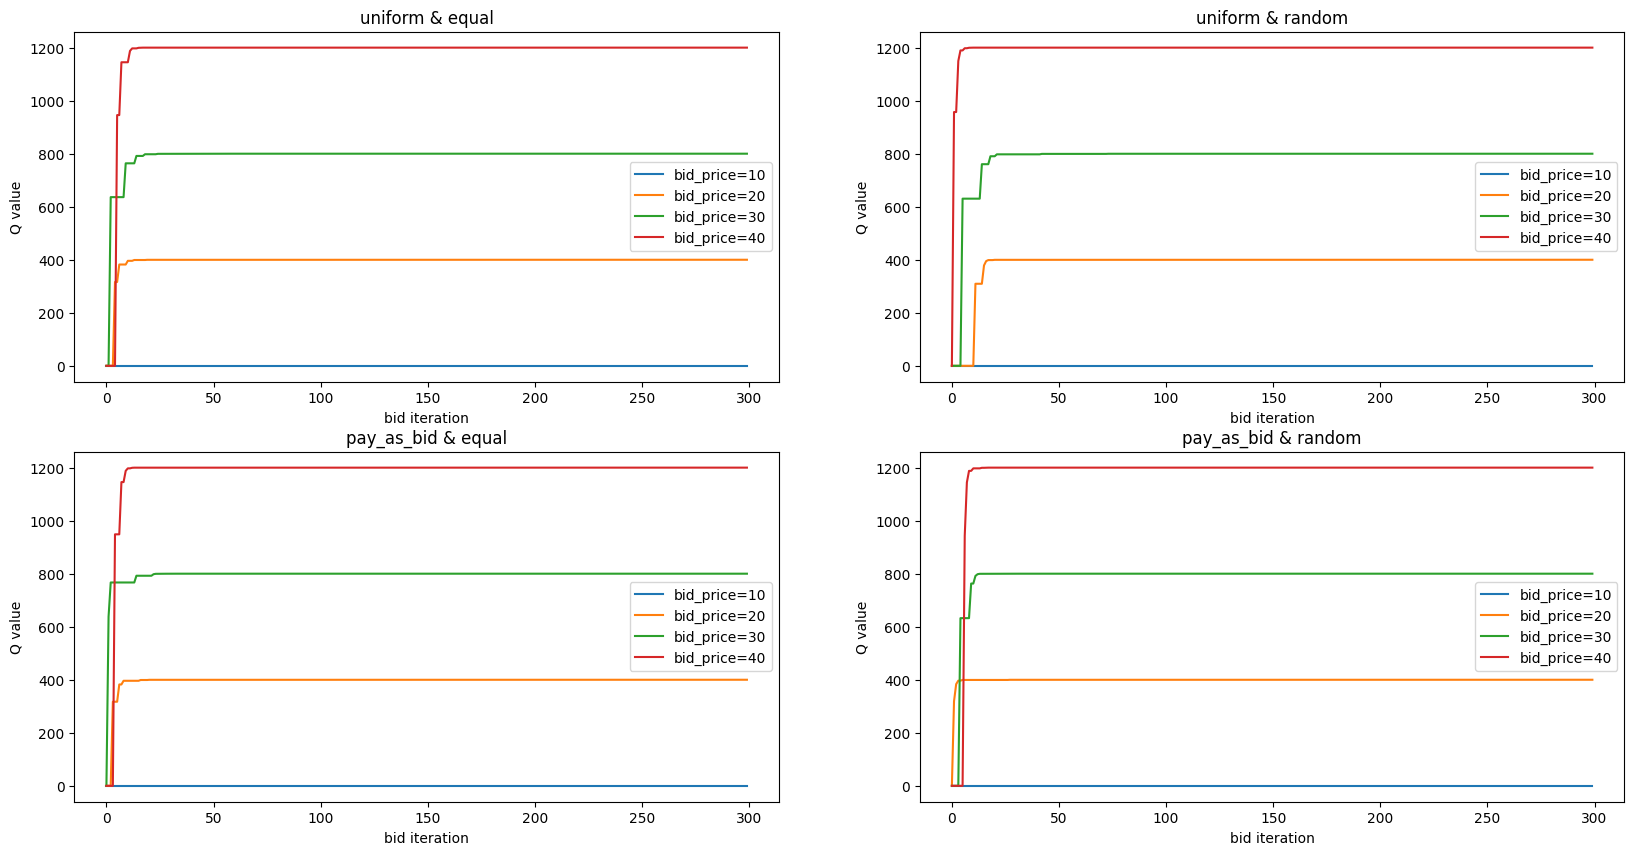

In [18]:
figure = plt.figure(figsize=(20, 10))
titles = ['uniform & equal',  'uniform & random', 'pay_as_bid & equal', 'pay_as_bid & random']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(gencos_1_Q_history[i], label=[f'bid_price={p}' for p in [10, 20, 30, 40]])
    plt.legend()
    plt.title(f'{titles[i]}')
    plt.xlabel('bid iteration')
    plt.ylabel('Q value')



## Case 2: 

Two private GenCos and a public GenCo participate in a competitive market where only the private GenCos are learning agents.


In [49]:

gencos_3_Q_history = []
gencos_4_Q_history = []
for p in PRICE_RULES:
    for r in RATION_POLICIES:
        # public GenCo
        gencos_2 = Gencos(id=2, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10])

        # private GenCo
        gencos_3 = Gencos(id=3, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])
        gencos_4 = Gencos(id=4, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])

        gencos_list_2 = [gencos_2, gencos_3, gencos_4]

        run_simulation(gencos_list_2, max_t=300, price_rule=p, ration_policy=r)
        gencos_3_Q_history.append(gencos_3.Q_history)
        gencos_4_Q_history.append(gencos_4.Q_history)

# 	bid_list(price, volum, gencos_id) 		clear_price 	susccess_bids
1 	 [(10, 60, 2), (10, 60, 4), (30, 60, 3)] 			 10 		 [(10, 50.0, 2), (10, 50.0, 4), (10, 0, 3)]
2 	 [(10, 60, 2), (10, 60, 4), (30, 60, 3)] 			 10 		 [(10, 50.0, 2), (10, 50.0, 4), (10, 0, 3)]
3 	 [(10, 60, 2), (10, 60, 3), (30, 60, 4)] 			 10 		 [(10, 50.0, 2), (10, 50.0, 3), (10, 0, 4)]
4 	 [(10, 60, 2), (20, 60, 4), (30, 60, 3)] 			 20 		 [(20, 60, 2), (20, 40.0, 4), (20, 0, 3)]
5 	 [(10, 60, 2), (10, 60, 4), (40, 60, 3)] 			 10 		 [(10, 50.0, 2), (10, 50.0, 4), (10, 0, 3)]
6 	 [(10, 60, 2), (20, 60, 3), (40, 60, 4)] 			 20 		 [(20, 60, 2), (20, 40.0, 3), (20, 0, 4)]
7 	 [(10, 60, 2), (20, 60, 4), (30, 60, 3)] 			 20 		 [(20, 60, 2), (20, 40.0, 4), (20, 0, 3)]
8 	 [(10, 60, 2), (20, 60, 3), (30, 60, 4)] 			 20 		 [(20, 60, 2), (20, 40.0, 3), (20, 0, 4)]
9 	 [(10, 60, 2), (20, 60, 3), (20, 60, 4)] 			 20 		 [(20, 60, 2), (20, 20.0, 3), (20, 20.0, 4)]
10 	 [(10, 60, 2), (20, 60, 4), (30, 60, 3)] 			 20 		 [(20, 60, 2),

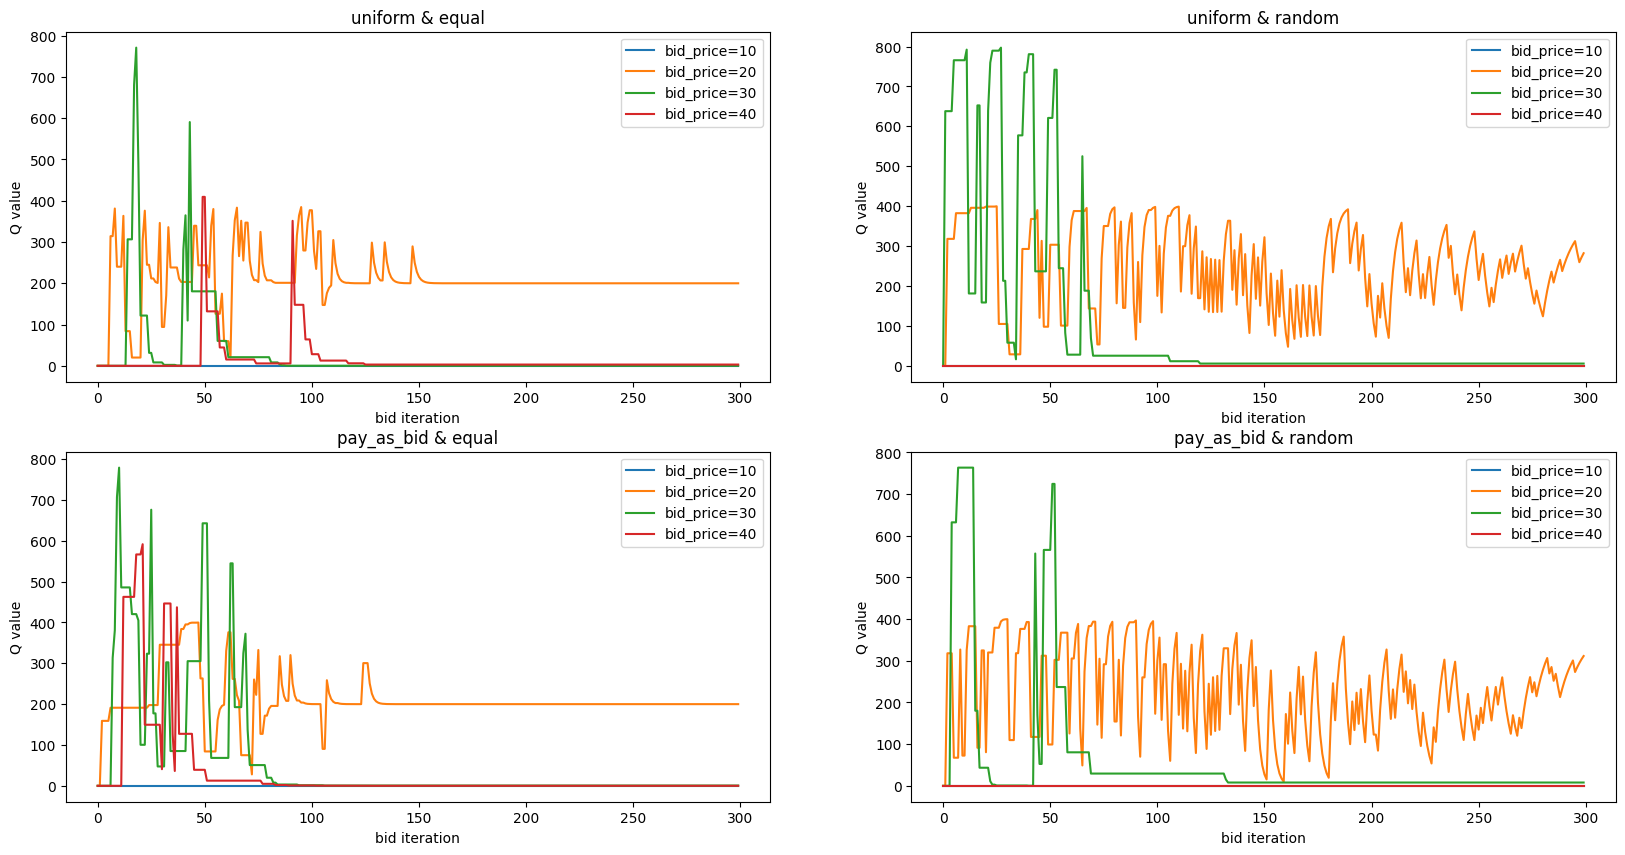

In [50]:
figure = plt.figure(figsize=(20, 10))
titles = ['uniform & equal',  'uniform & random', 'pay_as_bid & equal', 'pay_as_bid & random']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(gencos_3_Q_history[i], label=[f'bid_price={p}' for p in [10, 20, 30, 40]])
    plt.legend()
    plt.title(f'{titles[i]}')
    plt.xlabel('bid iteration')
    plt.ylabel('Q value')

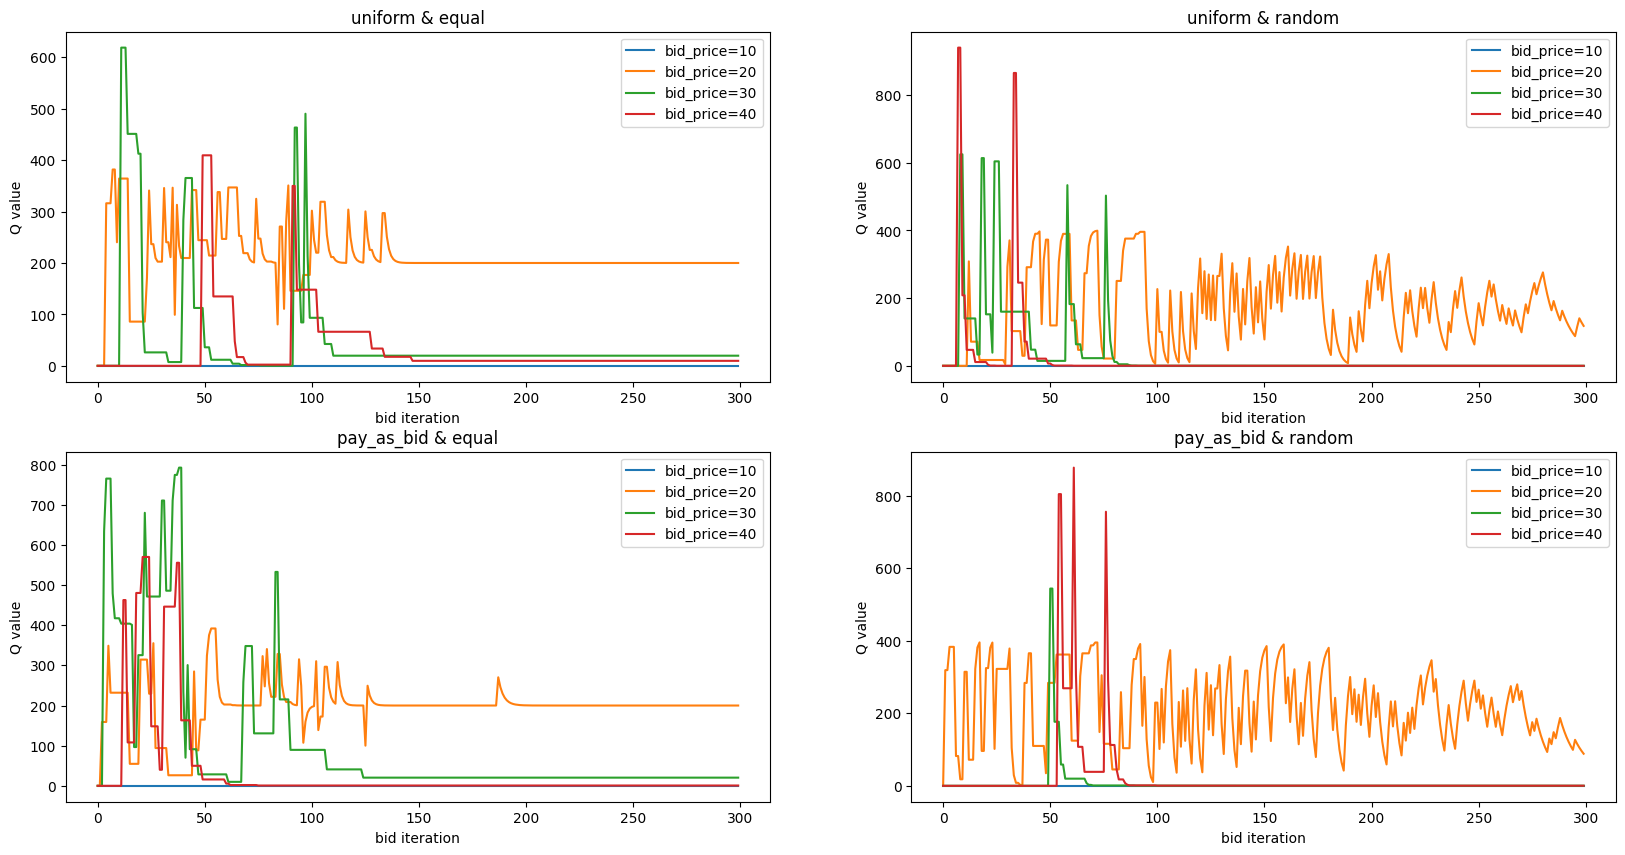

In [51]:
figure = plt.figure(figsize=(20, 10))
titles = ['uniform & equal',  'uniform & random', 'pay_as_bid & equal', 'pay_as_bid & random']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(gencos_4_Q_history[i], label=[f'bid_price={p}' for p in [10, 20, 30, 40]])
    plt.legend()
    plt.title(f'{titles[i]}')
    plt.xlabel('bid iteration')
    plt.ylabel('Q value')

## Case 3: 

The public GenCo in Case 2 is replaced with a learning GenCo.


In [61]:
gencos_5_Q_history = []
gencos_6_Q_history = []
for p in PRICE_RULES:
    for r in RATION_POLICIES:
       # private GenCo
        gencos_5 = Gencos(id=5, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])
        gencos_6 = Gencos(id=6, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])
        gencos_7 = Gencos(id=7, cost=10, pmax=60, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])

        gencos_list_3 = [gencos_5, gencos_6, gencos_7]

        run_simulation(gencos_list_3, max_t=300, price_rule=p, ration_policy=r)
        gencos_5_Q_history.append(gencos_5.Q_history)
        gencos_6_Q_history.append(gencos_6.Q_history)

# 	bid_list(price, volum, gencos_id) 		clear_price 	susccess_bids
1 	 [(20, 60, 7), (30, 60, 5), (30, 60, 6)] 			 30 		 [(30, 60, 7), (30, 20.0, 5), (30, 20.0, 6)]
2 	 [(30, 60, 5), (40, 60, 6), (40, 60, 7)] 			 40 		 [(40, 60, 5), (40, 20.0, 6), (40, 20.0, 7)]
3 	 [(10, 60, 7), (30, 60, 5), (30, 60, 6)] 			 30 		 [(30, 60, 7), (30, 20.0, 5), (30, 20.0, 6)]
4 	 [(10, 60, 7), (30, 60, 5), (40, 60, 6)] 			 30 		 [(30, 60, 7), (30, 40.0, 5), (30, 0, 6)]
5 	 [(10, 60, 7), (20, 60, 6), (30, 60, 5)] 			 20 		 [(20, 60, 7), (20, 40.0, 6), (20, 0, 5)]
6 	 [(30, 60, 6), (40, 60, 5), (40, 60, 7)] 			 40 		 [(40, 60, 6), (40, 20.0, 5), (40, 20.0, 7)]
7 	 [(30, 60, 5), (30, 60, 6), (30, 60, 7)] 			 30 		 [(30, 33.333333333333336, 5), (30, 33.333333333333336, 6), (30, 33.333333333333336, 7)]
8 	 [(10, 60, 5), (20, 60, 7), (30, 60, 6)] 			 20 		 [(20, 60, 5), (20, 40.0, 7), (20, 0, 6)]
9 	 [(10, 60, 5), (40, 60, 6), (40, 60, 7)] 			 40 		 [(40, 60, 5), (40, 20.0, 6), (40, 20.0, 7)]
10 	 [(10, 60, 5)

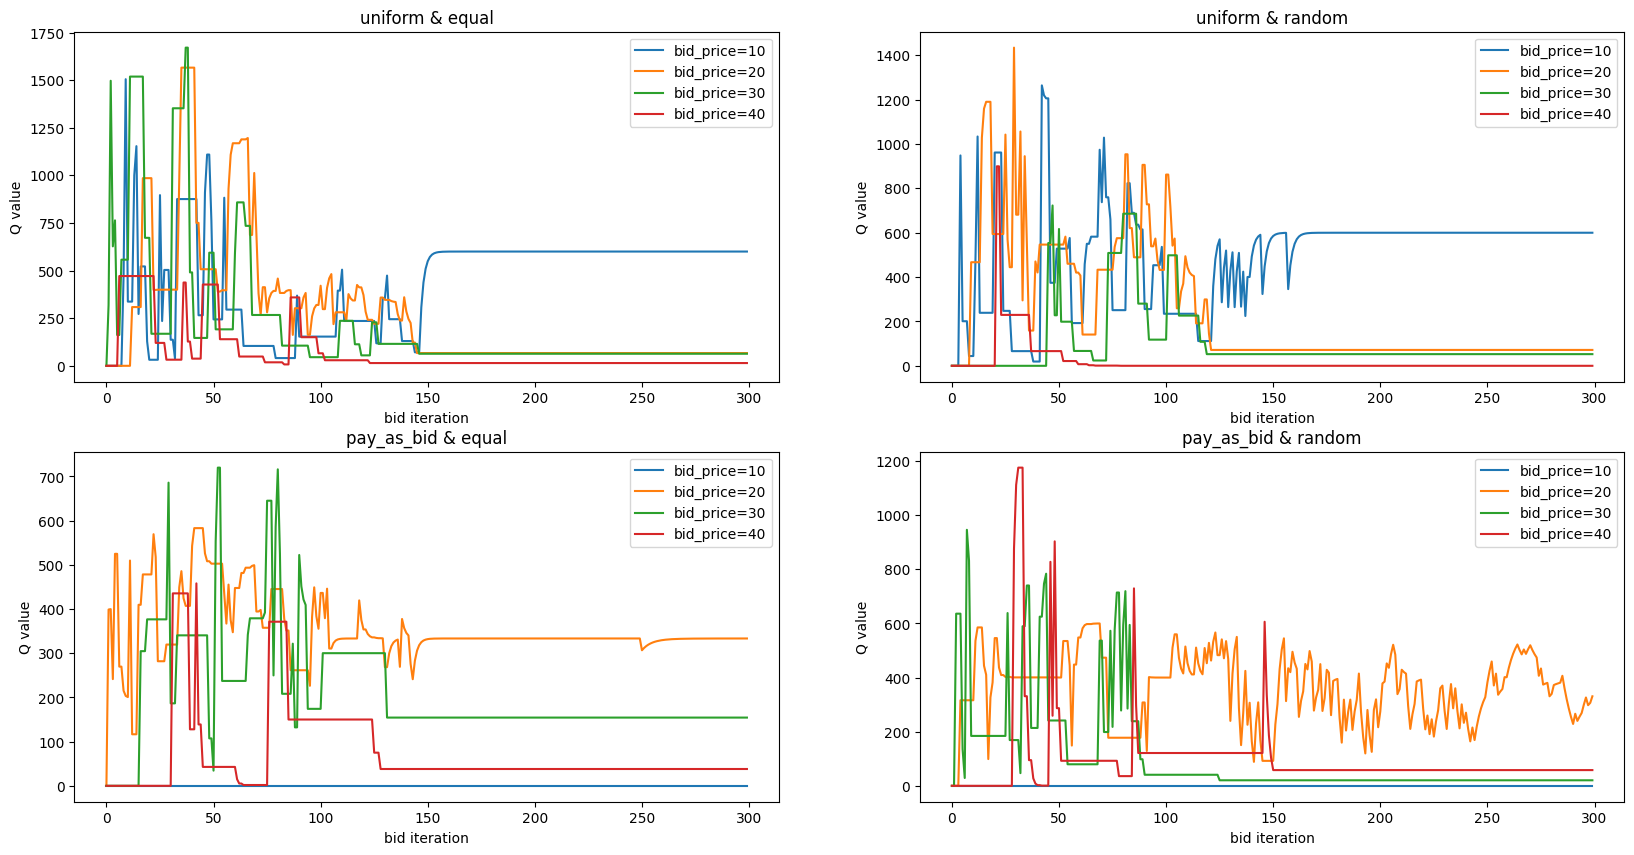

In [62]:
figure = plt.figure(figsize=(20, 10))
titles = ['uniform & equal',  'uniform & random', 'pay_as_bid & equal', 'pay_as_bid & random']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(gencos_5_Q_history[i], label=[f'bid_price={p}' for p in [10, 20, 30, 40]])
    plt.legend()
    plt.title(f'{titles[i]}')
    plt.xlabel('bid iteration')
    plt.ylabel('Q value')

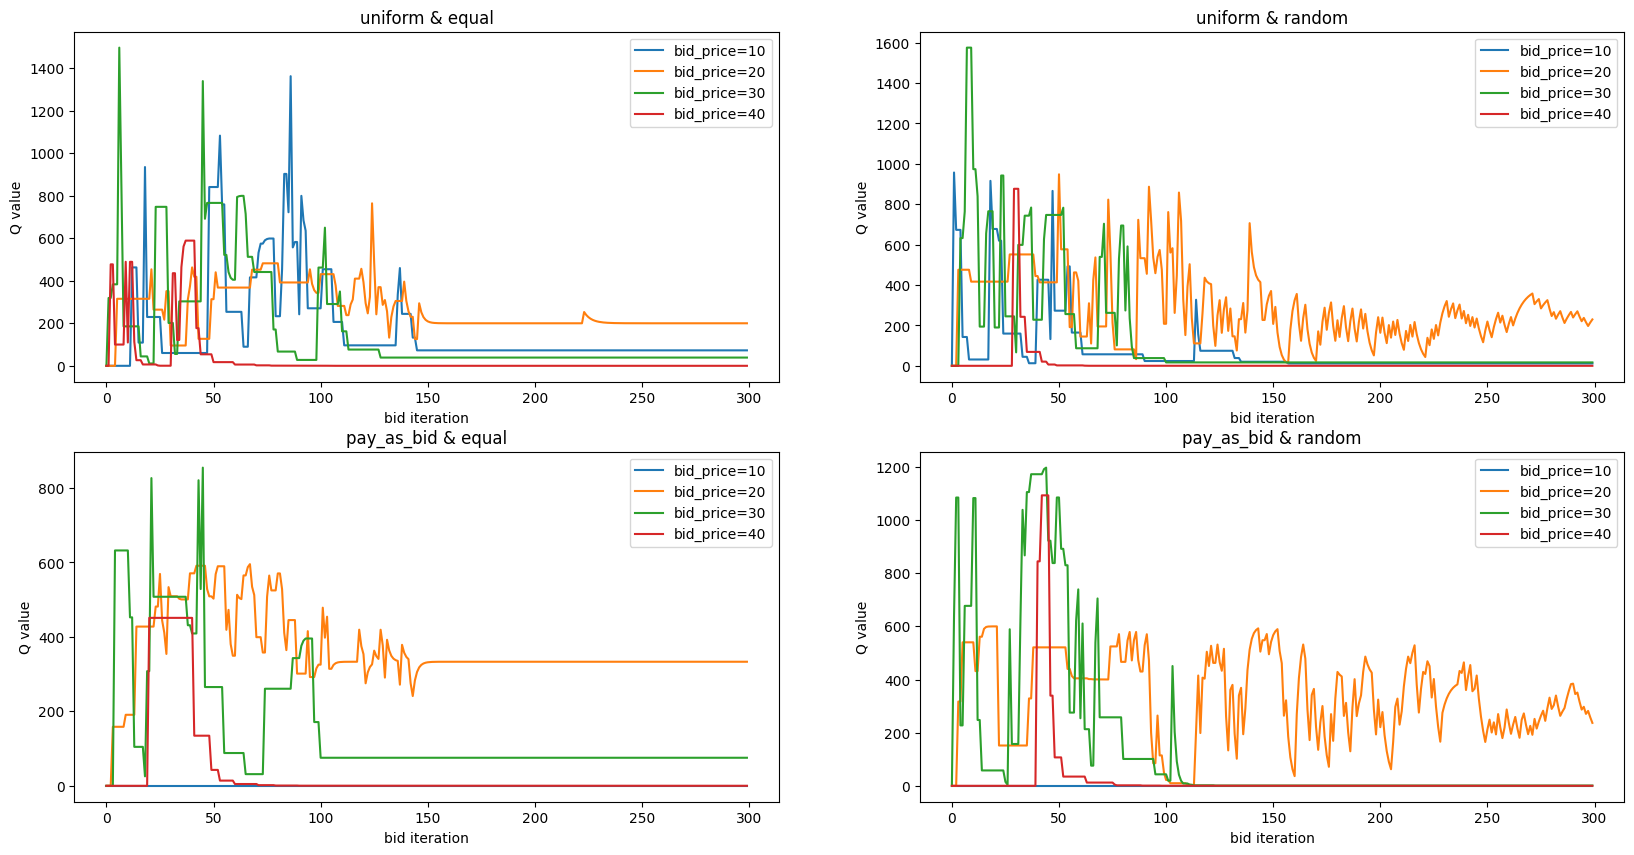

In [63]:
figure = plt.figure(figsize=(20, 10))
titles = ['uniform & equal',  'uniform & random', 'pay_as_bid & equal', 'pay_as_bid & random']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(gencos_6_Q_history[i], label=[f'bid_price={p}' for p in [10, 20, 30, 40]])
    plt.legend()
    plt.title(f'{titles[i]}')
    plt.xlabel('bid iteration')
    plt.ylabel('Q value')

## Case 4: 

Three learning GenCos compete to satisfy demand of a single node. As the demand can be satisfied to a great extent by any one of three GenCos, competition between GenCos is tight.

In [64]:
gencos_8_Q_history = []
gencos_9_Q_history = []
gencos_10_Q_history = []
for p in PRICE_RULES:
    for r in RATION_POLICIES:
       # private GenCo
        gencos_8 = Gencos(id=8, cost=10, pmax=160, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])
        gencos_9 = Gencos(id=9, cost=10, pmax=160, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])
        gencos_10 = Gencos(id=10, cost=10, pmax=160, epsilon=0.8, alpha=0.8, bid_prices=[10, 20, 30, 40])

        gencos_list_4 = [gencos_8, gencos_9, gencos_10]

        run_simulation(gencos_list_4, max_t=300, price_rule=p, ration_policy=r)
        gencos_8_Q_history.append(gencos_8.Q_history)
        gencos_9_Q_history.append(gencos_9.Q_history)
        gencos_10_Q_history.append(gencos_10.Q_history)

# 	bid_list(price, volum, gencos_id) 		clear_price 	susccess_bids
1 	 [(10, 160, 9), (10, 160, 10), (20, 160, 8)] 			 10 		 [(10, 50.0, 9), (10, 50.0, 10), (10, 0, 8)]
2 	 [(20, 160, 8), (20, 160, 10), (30, 160, 9)] 			 20 		 [(20, 50.0, 8), (20, 50.0, 10), (20, 0, 9)]
3 	 [(10, 160, 10), (20, 160, 8), (30, 160, 9)] 			 10 		 [(10, 100.0, 10), (10, 0, 8), (10, 0, 9)]
4 	 [(20, 160, 10), (40, 160, 8), (40, 160, 9)] 			 20 		 [(20, 100.0, 10), (20, 0, 8), (20, 0, 9)]
5 	 [(10, 160, 10), (20, 160, 8), (40, 160, 9)] 			 10 		 [(10, 100.0, 10), (10, 0, 8), (10, 0, 9)]
6 	 [(20, 160, 9), (20, 160, 10), (40, 160, 8)] 			 20 		 [(20, 50.0, 9), (20, 50.0, 10), (20, 0, 8)]
7 	 [(10, 160, 9), (30, 160, 8), (30, 160, 10)] 			 10 		 [(10, 100.0, 9), (10, 0, 8), (10, 0, 10)]
8 	 [(20, 160, 8), (20, 160, 9), (40, 160, 10)] 			 20 		 [(20, 50.0, 8), (20, 50.0, 9), (20, 0, 10)]
9 	 [(20, 160, 8), (20, 160, 10), (40, 160, 9)] 			 20 		 [(20, 50.0, 8), (20, 50.0, 10), (20, 0, 9)]
10 	 [(20, 160, 8), (30,

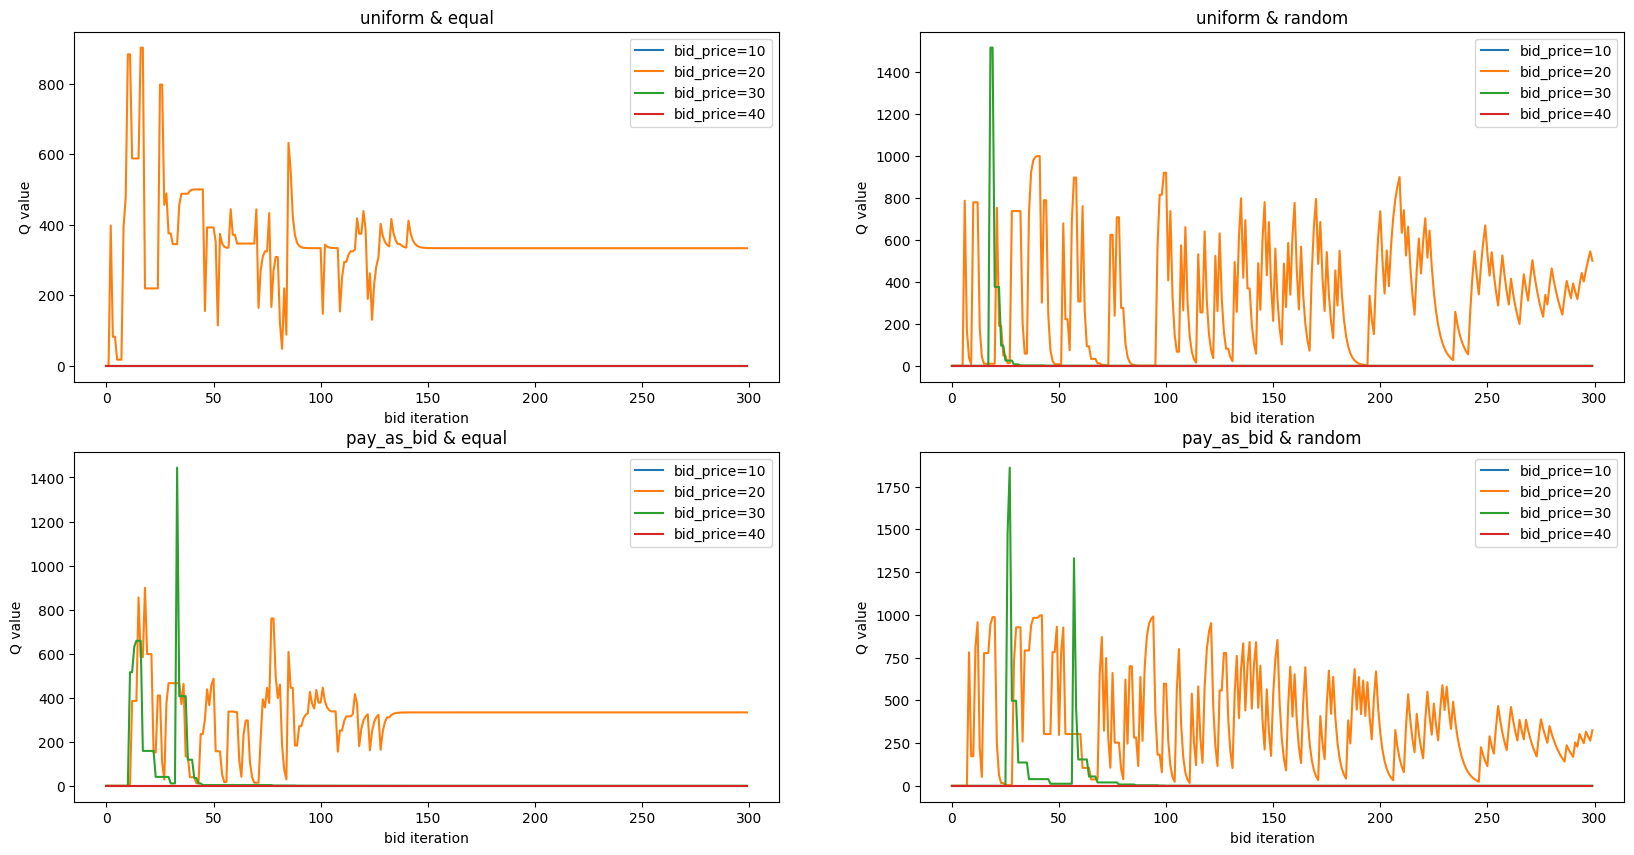

In [65]:
figure = plt.figure(figsize=(20, 10))
titles = ['uniform & equal',  'uniform & random', 'pay_as_bid & equal', 'pay_as_bid & random']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(gencos_8_Q_history[i], label=[f'bid_price={p}' for p in [10, 20, 30, 40]])
    plt.legend()
    plt.title(f'{titles[i]}')
    plt.xlabel('bid iteration')
    plt.ylabel('Q value')

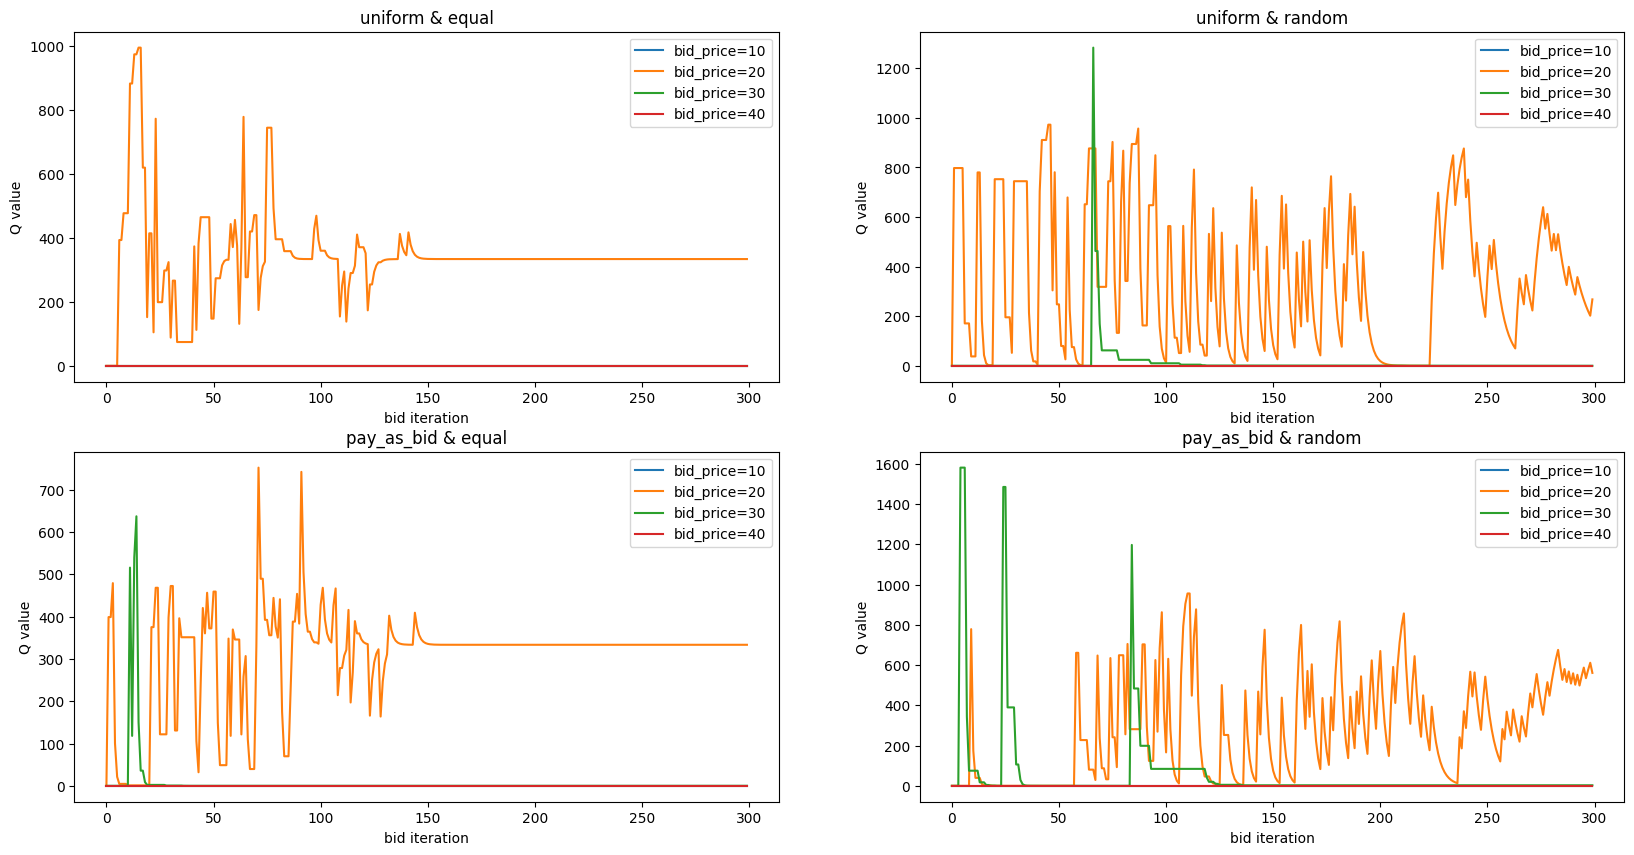

In [66]:
figure = plt.figure(figsize=(20, 10))
titles = ['uniform & equal',  'uniform & random', 'pay_as_bid & equal', 'pay_as_bid & random']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(gencos_9_Q_history[i], label=[f'bid_price={p}' for p in [10, 20, 30, 40]])
    plt.legend()
    plt.title(f'{titles[i]}')
    plt.xlabel('bid iteration')
    plt.ylabel('Q value')